In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os

In [2]:
transform=transforms.Compose([transforms.ToTensor()])

In [3]:
dataset=datasets.ImageFolder('/kaggle/input/shoes-dataset-real-and-ai-generated-images',transform=transform)
total_set=len(dataset)
train_size=int(0.6*total_set)
val_size=int(0.2*total_set)
test_size=total_set-train_size-val_size

train_dataset,remaining_dataset=random_split(dataset,[train_size,total_set-train_size])
val_dataset,test_dataset=random_split(remaining_dataset,[val_size,test_size])

In [4]:
batch_size=32

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

print(f"Training batches:{len(train_loader)}")
print(f"validation batches:{len(val_loader)}")
print(f"Testing batches;{len(test_loader)}")

for X,y in train_loader:
    print("Training batch -X shape :",X.shape,"Y shape :",y.shape)
    break
for X,y in val_loader:
    print("Validation batch -X shape:",X.shape,"Y shape: ",y.shape)
    break
for X,y in test_loader:
    print("Testing batch -X shape:",X.shape, "Y shape: ",y.shape)
    break

Training batches:41
validation batches:14
Testing batches;14
Training batch -X shape : torch.Size([32, 3, 240, 240]) Y shape : torch.Size([32])
Validation batch -X shape: torch.Size([32, 3, 240, 240]) Y shape:  torch.Size([32])
Testing batch -X shape: torch.Size([32, 3, 240, 240]) Y shape:  torch.Size([32])


In [5]:
class_dict={
    0:"AI",
    1:"Real"
}

batch=next(iter(train_loader))
images,labels=batch
images=images.numpy()

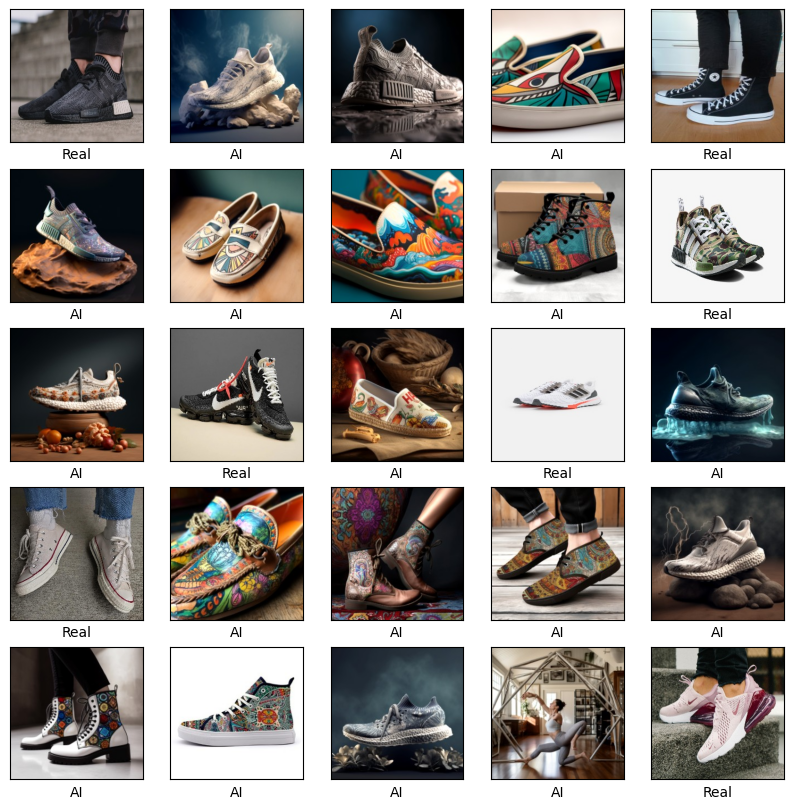

In [6]:
def view_samples():
    plt.figure(figsize=(10, 10))
    for index in range(25):
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = np.transpose(images[index], (1, 2, 0))
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(class_dict[labels[index].item()])
    plt.show()


view_samples()

In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels=len(class_dict)
print(torch.cuda.is_available())

True


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),  # 238 x 238 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3),  # 236 x 236 x 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 118 x 118 x 32
            nn.Conv2d(32, 64, kernel_size=3),  # 116 x 116 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3),  # 114 x 114 x 64
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), # 57 x 57 x 64
            nn.Conv2d(64, 128, kernel_size=3),  # 55 x 55 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3),  # 53 x 53 x 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2), # 26 x 26 x 128
            nn.Flatten(),
            nn.Linear(in_features=26*26*128, out_features=512),
            nn.ReLU(),
            nn.Linear(512, 2),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.float().to(device), y.long().to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(
        f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n"
    )
    return average_train_loss, train_accuracy

def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.float().to(device), y.long().to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(
        f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n"
    )
    return average_val_loss, val_accuracy


def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    correct_examples = []
    incorrect_examples = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.float().to(device), y.long().to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predicted.tolist())
            matches = predicted == y
            for i in range(len(matches)):
                example = (X[i].cpu(), y[i].item(), predicted[i].item())  # Store tensor as CPU tensor, labels as items
                if matches[i]:
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy, correct_examples, incorrect_examples


In [10]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
epochs = 10
max_acc = 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc

        # Saving State Dict
        torch.save(model.state_dict(), "/kaggle/working/saved_model.pth")
print("Done!")

Epoch 1
-------------------------------
loss: 0.672504  [   32/ 1308]
loss: 6.143410  [  352/ 1308]
loss: 6.910865  [  672/ 1308]
loss: 3.041059  [  992/ 1308]
loss: 1.242244  [ 1308/ 1308]
Training Error: 
 Accuracy: 84.3%, Avg loss: 4.247202 

Validation Error: 
 Accuracy: 82.1%, Validation loss: 4.373731 

[SAVING] Validation Accuracy Increased(0.0% ---> 82.1%)
Epoch 2
-------------------------------
loss: 1.421497  [   32/ 1308]
loss: 0.548089  [  352/ 1308]
loss: 0.064520  [  672/ 1308]
loss: 0.063355  [  992/ 1308]
loss: 0.105118  [ 1308/ 1308]
Training Error: 
 Accuracy: 92.3%, Avg loss: 0.401085 

Validation Error: 
 Accuracy: 93.6%, Validation loss: 0.619788 

[SAVING] Validation Accuracy Increased(82.1% ---> 93.6%)
Epoch 3
-------------------------------
loss: 0.149332  [   32/ 1308]
loss: 0.014926  [  352/ 1308]
loss: 0.033401  [  672/ 1308]
loss: 0.031727  [  992/ 1308]
loss: 0.262864  [ 1308/ 1308]
Training Error: 
 Accuracy: 96.4%, Avg loss: 0.133103 

Validation Error: 


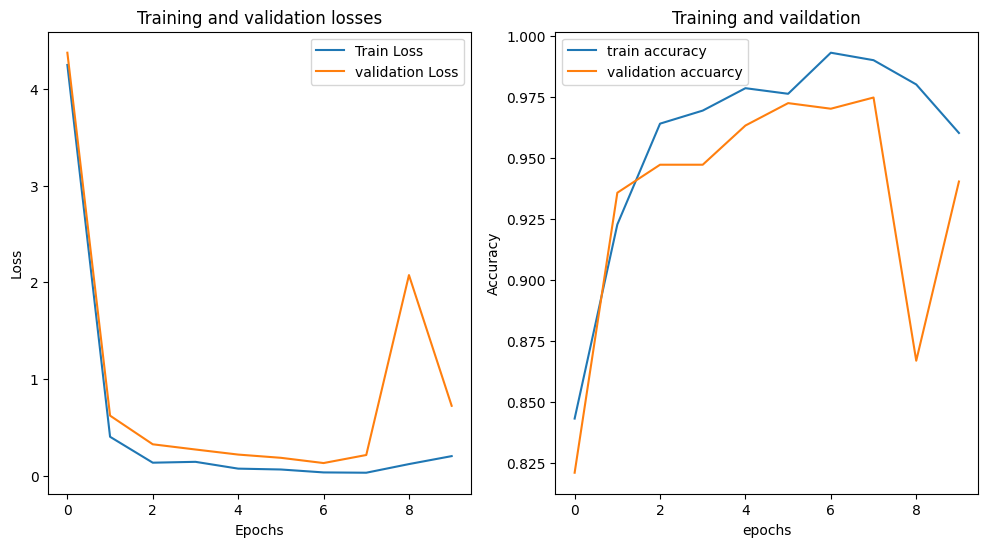

In [11]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="validation Loss")
plt.title("Training and validation losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,label="train accuracy")
plt.plot(val_accs,label="validation accuarcy")
plt.title("Training and vaildation")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [12]:
model.load_state_dict(torch.load("/kaggle/working/saved_model.pth"))
model.to(device)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU()
    (16): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

In [14]:
loss_fn=torch.nn.CrossEntropyLoss()

y_true,y_pred,test_loss,test_accuracy,correct_examples,incorrect_examples=evaluate_model(test_loader,model,loss_fn)
print(f"Test Loss:{test_loss}:.4f")
print(f"Test Accuracy:{test_accuracy:.4f}")

Test Loss:0.19747894816100597:.4f
Test Accuracy:0.9657


In [15]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       281
           1       0.95      0.96      0.95       156

    accuracy                           0.97       437
   macro avg       0.96      0.96      0.96       437
weighted avg       0.97      0.97      0.97       437



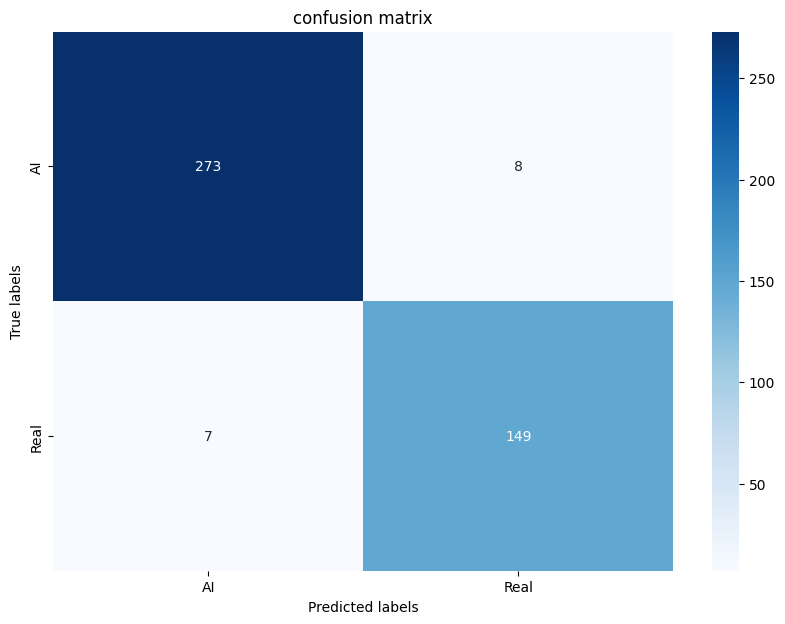

In [16]:
cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",xticklabels=list(class_dict.values()),yticklabels=list(class_dict.values()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('confusion matrix')
plt.show()

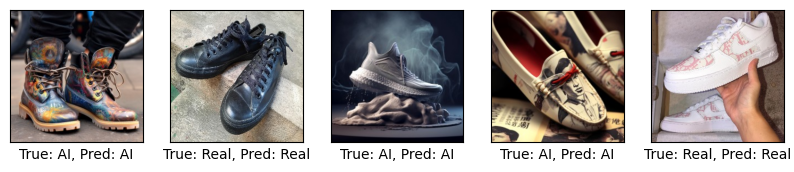

In [18]:
def display_examples(examples):
    plt.figure(figsize=(10, 10))
    for index, (image, true_label, pred_label) in enumerate(examples[:5]): 
        img = image.cpu().numpy().transpose((1, 2, 0))  
        plt.subplot(5, 5, index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(f"True: {class_dict[true_label]}, Pred: {class_dict[pred_label]}")
    plt.show()

display_examples(correct_examples)